In [1]:
import os
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 12})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def rename_raw_reads(row):
    rename_dict = {"R1": "pair1", "R2": "pair2"}
    if row.read_type == "raw_reads":
        split_rep = row.replicate.split("_")
        read_type = "raw_reads" + "_" + rename_dict[split_rep[-1]]
        rep = "_".join(split_rep[:-1])
    else:
        read_type = row.read_type
        rep = row.replicate

    return pd.Series({
        "read_type": read_type, 
        "replicate": rep, 
        "read_num": row.read_num
        })


# Our libraries

In [3]:
### Put in place manually ###
### Obtained directly from log files ###

lib_names = ["input", "control"]

read_qc_input_df = pd.DataFrame({
    "replicates": [
        "rep_1", "rep_2", "rep_3",
        "rep_1", "rep_2", "rep_3",
        "rep_1", "rep_2", "rep_3"
        ],
    "read_type": [
        "deduped_reads_pair1", "deduped_reads_pair1", "deduped_reads_pair1", 
        "lowqual_reads_pair1", "lowqual_reads_pair1", "lowqual_reads_pair1",
        "filtered_reads_pair1", "filtered_reads_pair1", "filtered_reads_pair1",
        ],
    "reads_percent": [
        9.625557385, 9.575100803, 9.42483141,
        15.74704739, 16.58508892, 16.81113742,
        25.68510062, 25.38928658, 25.39172609
        ]
})

read_qc_output_df = pd.DataFrame({
    "replicates": [
        "rep_1", "rep_2", "rep_3",
        "rep_1", "rep_2", "rep_3",
        "rep_1", "rep_2", "rep_3"
        ],
    "read_type": [
        "deduped_reads_pair1", "deduped_reads_pair1", "deduped_reads_pair1", 
        "lowqual_reads_pair1", "lowqual_reads_pair1", "lowqual_reads_pair1",
        "filtered_reads_pair1", "filtered_reads_pair1", "filtered_reads_pair1",
        ],
    "reads_percent": [
        10.44290423, 9.804780338, 11.54857247,
        18.06114546, 18.98664952, 18.41736294,
        27.30255393, 27.28568978, 26.47057287,
        ]
})

In [4]:
read_qc_input_df["library"] = "input"
read_qc_output_df["library"] = "output"
read_qc_df_our_lib = pd.concat([read_qc_input_df, read_qc_output_df])
read_qc_df_our_lib["dataset"] = "In-house dataset"

# Kellis Wang libraries

In [5]:
def get_read_qc_df(dataset, lib_name, lib_stats_file):
    df_input = pd.read_csv(lib_stats_file, header=None, skiprows=3, names=["read_type", "replicate", "read_num"])
    # filter out coverage rows from stats file
    df_input = df_input.loc[df_input.read_type!="coverage"]
    # rename raw reads to include read pair information
    df_input = df_input.apply(rename_raw_reads, axis=1)
    df_input = df_input.pivot(index=["read_type"], columns=["replicate"], values=["read_num"])
    # only keep pair1
    df_input_pair1 = df_input.loc[df_input.index.str.contains("pair1")]
    df_input_pair1.columns = [t[1] for t in df_input_pair1.columns]
    # calculate unmapped reads
    unmapped_reads_series = df_input_pair1.loc["raw_reads_pair1"] - df_input_pair1.loc["aligned_reads_pair1"]
    unmapped_reads_series.name = "unmapped_reads_pair1"
    # calculate deduped reads
    deduped_reads_series = df_input_pair1.loc["aligned_reads_pair1"] - df_input_pair1.loc["deduped_reads_pair1"]
    deduped_reads_series.name = "deduped_reads_pair1"
    # calculate low qual reads
    lowqual_reads_series = df_input_pair1.loc["deduped_reads_pair1"] - df_input_pair1.loc["filtered_reads_pair1"]
    lowqual_reads_series.name = "lowqual_reads_pair1"
    df_qc = pd.concat([deduped_reads_series, lowqual_reads_series, df_input_pair1.loc["filtered_reads_pair1"]], axis=1)
    df_qc = df_qc.div(df_input_pair1.loc["raw_reads_pair1"], axis=0)*100
    df_qc["library"] = lib_name
    df_qc["dataset"] = dataset
    return df_qc.reset_index().rename(columns={"index": "replicates"}).melt(id_vars=["dataset", "library", "replicates"], var_name="read_type", value_name="reads_percent")

In [6]:
lib_names = ["input", "output"]
lib_stats_files = [
    "../data/wang/table/IN/stats.csv", 
    "../data/wang/table/OUT/stats.csv"
    ]

In [7]:
read_qc_dfs = [get_read_qc_df("Wang_Kellis", ln, lsf) for ln,lsf in zip(lib_names, lib_stats_files)]

In [8]:
read_qc_df_wang_kellis = pd.concat(read_qc_dfs)

# Johnson Reddy libraries

In [9]:
lib_names = ["input", "output"]
lib_stats_files = [
    "../data/johnson/table/IN/stats.csv", 
    "../data/johnson/table/OUT/stats.csv"
    ]

read_qc_dfs = [get_read_qc_df("Johnson_Reddy", ln, lsf) for ln,lsf in zip(lib_names, lib_stats_files)]



In [10]:
read_qc_df_johnson_reddy = pd.concat(read_qc_dfs)

In [11]:
read_qc_df = pd.concat([read_qc_df_our_lib, read_qc_df_wang_kellis, read_qc_df_johnson_reddy])

# Figure S2

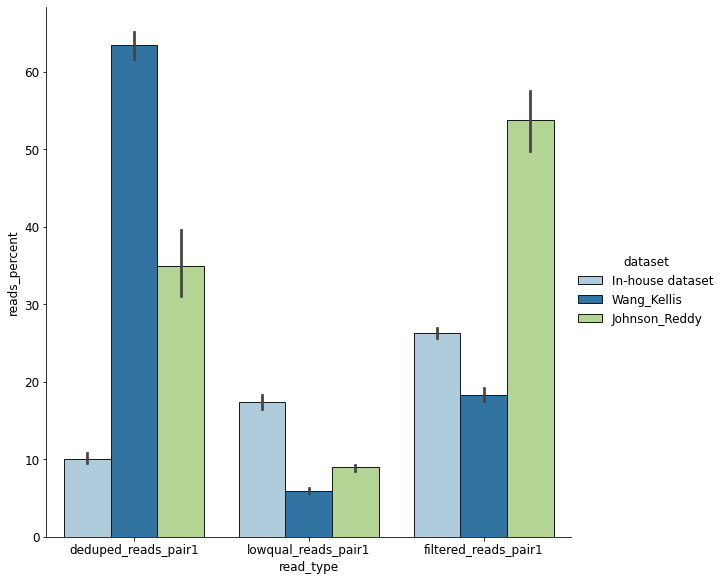

In [12]:
c = sns.catplot(
    data=read_qc_df, 
    x="read_type", 
    y="reads_percent", 
    kind="bar", 
    hue="dataset", 
    edgecolor=".1",
    aspect=1, 
    height=8, 
    dodge=True,
    palette="Paired",
    )
